A Gated Recurrent Unit (GRU) is a variant of the RNN architecture, and uses gating mechanisms to control and manage the flow of information between cells in the neural network. GRUs were introduced only in 2014 by Cho, et al.
We’ll be implementing a GRU model in code. To further our GRU-LSTM comparison, we’ll also be using an LSTM model to complete the same task. We’ll evaluate the performance of both models on a few metrics.

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

### defining hyperparameters

In [18]:
input_size=28
sequence_length =28
num_layers=2
hidden_size=128

learning_rate = 0.001
num_epochs = 5

num_classes =10
batch_size = 256

## lets design an rnn

In [19]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=input_size, num_layers=num_layers, hidden_size=hidden_size, sequence_length=sequence_length, num_classes=num_classes):
        super(SimpleRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size= hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size * sequence_length, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        return out
    

### A GRU

In [20]:
class SimpleGRU(nn.Module):
    def __init__(self, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes, sequence_length=sequence_length):
        super(SimpleGRU, self).__init__()
        self.hidden_size  = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size * sequence_length, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out,_ = self.gru(x, h0) 
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        return out
        
        

### A LSTM

In [21]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, sequence_length=sequence_length, num_classes=num_classes):
        super(SimpleLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size * sequence_length, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=device)
        
        out, _ = self.lstm(x,(h0, c0))
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        return out

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
model = SimpleRNN().to(device=device)

#model = SimpleGRU().to(device=device)

#model = SimpleLSTM().to(device=device)

In [24]:
x = torch.randn(256,28,28).to(device=device)
y = model(x)
y.shape

torch.Size([256, 10])

In [25]:
import pandas as pd
import numpy as np

class MnistDataset(Dataset):
    def __init__(self, datapath):
        super(MnistDataset).__init__()
        df = pd.read_csv(datapath, dtype=float)
        
        self.x = torch.from_numpy(df.iloc[:, 1:].values)
        self.x = self.x.reshape(self.x.size(0), 1, 28, 28).squeeze(1) # GRU and RNN expect N * 28 * 28
        self.x = self.x.float()
        
        self.y = torch.from_numpy(df.iloc[:, 0].values)
        self.y = self.y.long()
        
        self.n_samples = df.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
        

In [26]:
train_dataset = MnistDataset("mnist_train.csv")
test_dataset = MnistDataset("mnist_test.csv")

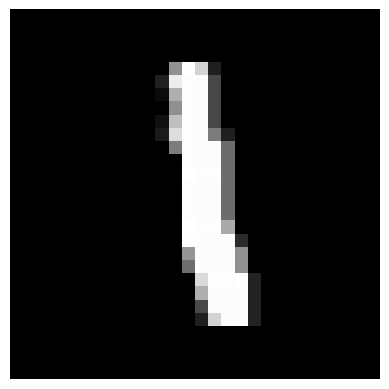

torch.Size([28, 28])
tensor(1)


In [27]:
x, y = train_dataset[6]
plt.imshow(x,cmap='gray')   #Display grayscale images
plt.axis('off')
plt.show()
print(x.shape)
print(y)

In [28]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [29]:
loss_criterion  = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [30]:
current_loss = 0
for epoch in range(num_epochs):
    for data, target in train_dataloader:
        data = data.to(device=device)
        target = target.to(device=device)
        
        score = model(data)
        loss = loss_criterion(score, target)
        current_loss = loss
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    print(f"At epoch: {epoch}, loss: {current_loss}")

At epoch: 0, loss: 0.05457757040858269
At epoch: 1, loss: 0.07467039674520493
At epoch: 2, loss: 0.0798235684633255
At epoch: 3, loss: 0.04159282520413399
At epoch: 4, loss: 0.0354028083384037


In [31]:
def check_accuracy(dlr, model):
    
    total_correct = 0
    total_samples = 0
    
    model.eval()
    
    with torch.no_grad():
        for x, y in dlr:
            x = x.to(device=device)
            y = y.to(device=device)
            
            score = model(x)
            _,predictions = score.max(1)
            
            total_correct += (y==predictions).sum()
            total_samples += predictions.size(0)
            
    model.train()
    print(f"total samples: {total_samples} total_correct: {total_correct} accuracy : {float(total_correct/total_samples)* 100}")
            

In [32]:
check_accuracy(train_dataloader, model)
check_accuracy(test_dataloader, model)

total samples: 60000 total_correct: 59072 accuracy : 98.45333099365234
total samples: 10000 total_correct: 9762 accuracy : 97.61999845504761
